In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon
from scipy.stats imports mannwhitneyu

sns.set_style("whitegrid")

SyntaxError: invalid syntax (704293999.py, line 9)

### Read in samples for origin ARS313, to set up the annotation of the nucleosome areas

## Wildtype

In [ ]:
load_dir =  "ARS313"

In [ ]:
ls ARS313/

In [229]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS313_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS313_end_LexA.txt")

#feature annotation
#anno = pd.read_csv(load_dir + "/Features from ARS313_end_LexA  (31 .. 1076).txt", sep  = "\t", 
#                          header = None, index_col = 0)
#anno.columns = ["position", "length"]

#anno = pd.read_csv(load_dir + "/coordinates_ARS313.txt", sep  = "\t", 
#                          header = None, index_col = 0)


anno = pd.read_csv(load_dir + "/ARS313_80bp.txt", sep  = "\t", 
                          header = None, index_col = 0)
anno.columns = ["position"]

anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

#anno["pos_start"] = anno.position.str.split(".").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split(".").str[2].astype(int) -1

anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

anno["length"] = anno.pos_stop - anno.pos_start

In [230]:
wt_rep3.shape

(780, 1033)

In [231]:
anno

,position,pos_start,pos_stop,length
0,,,,
+3ns,95-175,94,174,80
+2L,200-240,199,239,40
+2ns,325-405,324,404,80
+1ns,430-510,429,509,80
ARS313,520-600,519,599,80
-1ns,625-705,624,704,80
-1L,725-740,724,739,15
-2ns,775-855,774,854,80
-2L,870-880,869,879,10


In [232]:
wt_rep2.shape[1] == wt_rep3.shape[1]

True

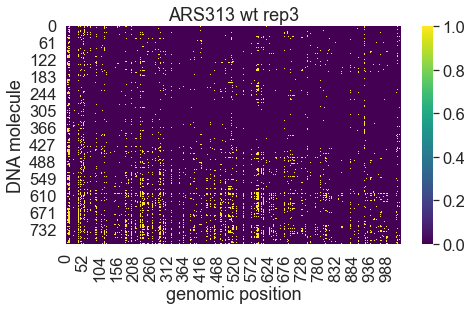

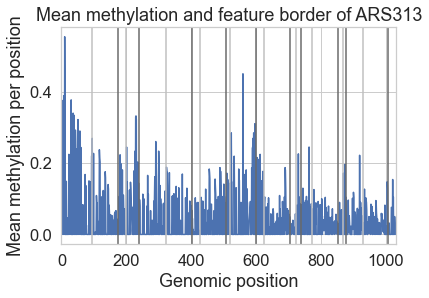

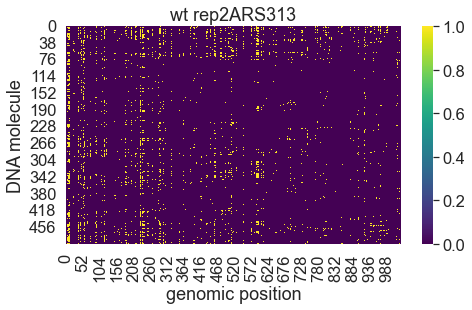

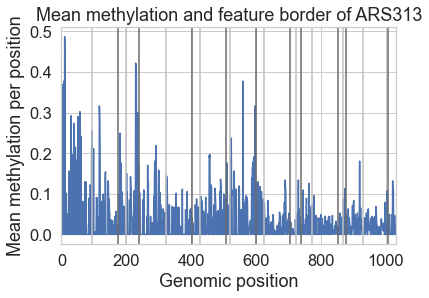

In [233]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title("wt rep2" + load_dir)
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

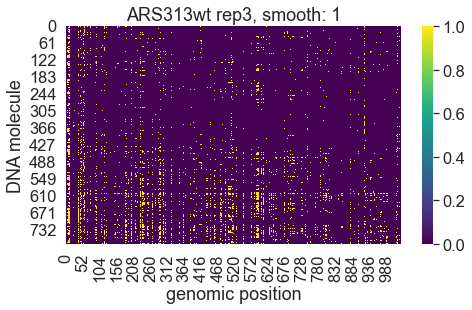

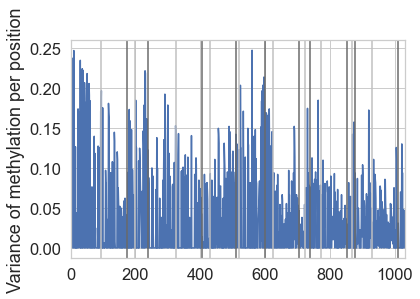

In [234]:
smooth_window = 1

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [235]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([9.77734753, 0.        , 0.        , ..., 1.3552759 , 0.        ,
       1.74249758])

<AxesSubplot:>

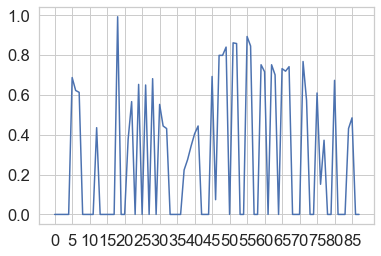

In [236]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

#entropy(ARS305_wt[:,6])
#np.unique(ARS305_wt[:,6], return_counts = True)

g = sns.lineplot(x = range(630-542), y = np.apply_along_axis(entropy, 0, wt_rep3[:, 542:630]))
g.set_xticks(range(0, 630-542, 5))
g

<AxesSubplot:title={'center':'ARS313 wt rep3, entropy per position'}, ylabel='entropy'>

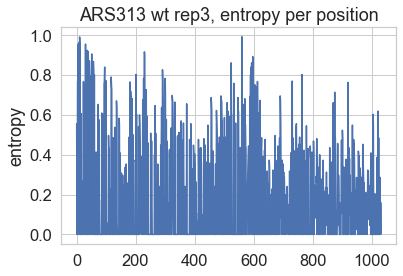

In [237]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [238]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.9927744539878083, 520)

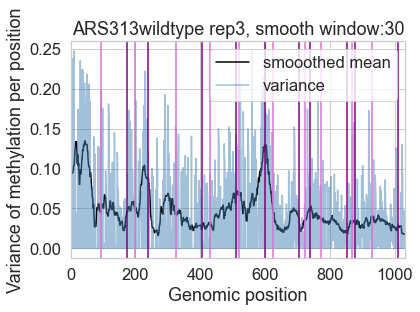

In [239]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  "wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

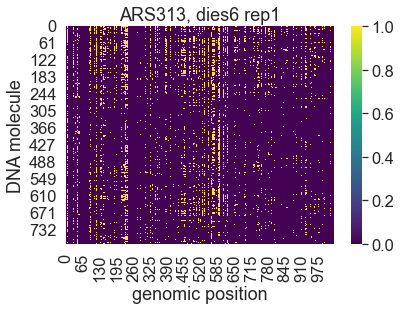

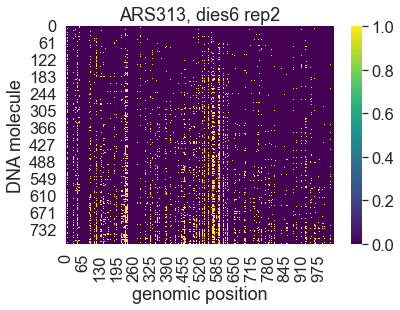

In [240]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS313_end_LexA.txt")
dies6_rep1.shape

sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS313_REP2_780READS.csv", dtype = int, delimiter = ",")
dies6_rep2.shape

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

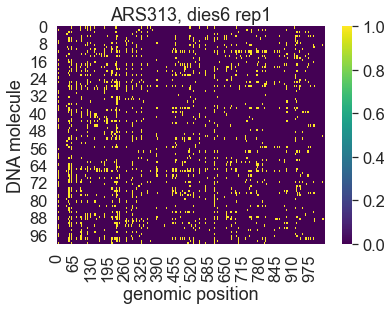

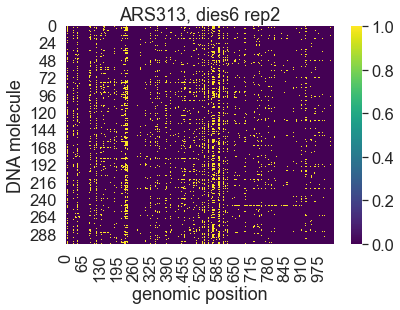

In [241]:
#subsample to the same number of molecules than in 316
#rep1 -> 83
#rep2 -> 301

#def subsample(df, n):
#    np.random.seed(0)
#    return df[np.random.RandomState(seed=24).choice(len(df), n)]

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

test1 = subsample(dies6_rep1, 100)
test2 = subsample(dies6_rep2, 300)

sns.heatmap(test1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(test2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

In [242]:
#subsample dies6 replicates to the same size as in 316, and oberserve the effect on differential
#methylation per feature in the below output

#dies6_rep1 = subsample(dies6_rep1, 83)
#dies6_rep2 = subsample(dies6_rep2, 301)

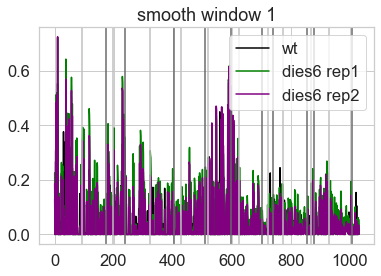

(25911.5, 6.310420035373084e-33)

In [243]:
#smooth_window=1
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [244]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=12994.5, pvalue=4.757990312696545e-54)

## Load data for mutant disw2

(780, 1033)


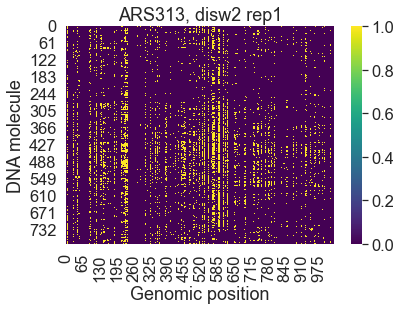

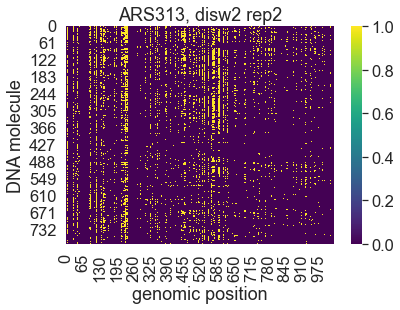

In [245]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS313_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape)

sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

disw2_rep2 = np.genfromtxt(load_dir + "/ARS313_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
disw2_rep2.shape

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

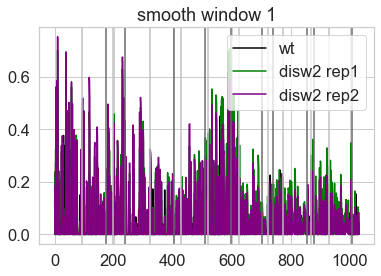

In [246]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [247]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(53848.5, 0.0003257881338903286)

### Min-max normalise each experiment and pool replicates

In [248]:
wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

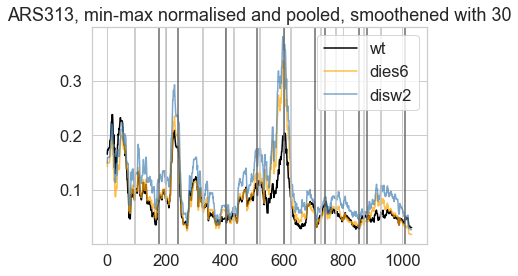

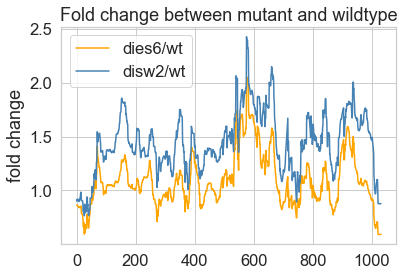

In [249]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "orange", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "steelblue", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", min-max normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

### Compare mean distributions between pooled replicates and pooled wildtype with paired wilcoxon test

In [250]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [251]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [252]:
#segments.to_csv(load_dir + "/ARS313_pooled_samples_two-sided-test.csv")

In [253]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
+3ns,94,174,80,0.000404,1.058637e-06
ARS313,519,599,80,0.001326,2.948415e-04
-3ns,929,1009,80,0.011203,5.062102e-07


In [254]:
#Regions significant for disw2:
print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
+3ns,94,174,80,0.000404,1.058637e-06
+2L,199,239,40,0.045865,1.548694e-03
+2ns,324,404,80,0.059935,1.834151e-03
+1ns,429,509,80,0.251332,4.034695e-05
ARS313,519,599,80,0.001326,2.948415e-04
-1ns,624,704,80,0.345373,2.020380e-03
-2ns,774,854,80,0.116098,1.114394e-04
-3ns,929,1009,80,0.011203,5.062102e-07


### Compare pooled wildtype to mutant replicates, then filter regions

In [255]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [256]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [257]:
#segments.to_csv(load_dir + "/ARS313_separate_replicates_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,0.000003,0.034038,1.330422e-06,0.000001
+2L,199,239,40,0.010817,0.935311,1.548694e-03,0.002155
+2ns,324,404,80,0.015100,0.829329,1.959823e-03,0.001960
+1ns,429,509,80,0.000553,0.012019,2.534874e-04,0.000045
ARS313,519,599,80,0.001758,0.001116,2.284270e-04,0.000456
-1ns,624,704,80,0.042276,0.472783,3.870086e-04,0.096601
-1L,724,739,15,0.858863,0.593712,3.739448e-01,0.476907
-2ns,774,854,80,0.007025,0.108103,8.016488e-05,0.000219
-2L,869,879,10,0.500184,0.043114,2.249159e-01,0.892738


In [258]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+1ns,429,509,80,0.000553,0.012019,2.534874e-04,0.000045
ARS313,519,599,80,0.001758,0.001116,2.284270e-04,0.000456
-3ns,929,1009,80,0.000006,0.000016,4.015790e-07,0.000001


In [259]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,0.000003,0.034038,1.330422e-06,0.000001
+2L,199,239,40,0.010817,0.935311,1.548694e-03,0.002155
+2ns,324,404,80,0.015100,0.829329,1.959823e-03,0.001960
+1ns,429,509,80,0.000553,0.012019,2.534874e-04,0.000045
ARS313,519,599,80,0.001758,0.001116,2.284270e-04,0.000456
-2ns,774,854,80,0.007025,0.108103,8.016488e-05,0.000219
-3ns,929,1009,80,0.000006,0.000016,4.015790e-07,0.000001


In [260]:
#Repeat this test for the case that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [261]:
test_higher

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,0.000002,0.982981,6.652111e-07,5.293184e-07
+2L,199,239,40,0.005409,0.467656,7.743470e-04,1.077469e-03
+2ns,324,404,80,0.007550,0.585335,9.799116e-04,9.799116e-04
+1ns,429,509,80,0.000277,0.993991,1.267437e-04,2.238898e-05
ARS313,519,599,80,0.000879,0.000558,1.142135e-04,2.281865e-04
-1ns,624,704,80,0.021138,0.763608,1.935043e-04,4.830048e-02
-1L,724,739,15,0.429432,0.703144,1.869724e-01,2.384533e-01
-2ns,774,854,80,0.003512,0.945948,4.008244e-05,1.094989e-04
-2L,869,879,10,0.250092,0.978443,1.124579e-01,4.463692e-01


In [262]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
ARS313,519,599,80,0.000879,0.000558,0.000114,0.000228


In [263]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,0.000002,0.982981,6.652111e-07,5.293184e-07
+2L,199,239,40,0.005409,0.467656,7.743470e-04,1.077469e-03
+2ns,324,404,80,0.007550,0.585335,9.799116e-04,9.799116e-04
+1ns,429,509,80,0.000277,0.993991,1.267437e-04,2.238898e-05
ARS313,519,599,80,0.000879,0.000558,1.142135e-04,2.281865e-04
-2ns,774,854,80,0.003512,0.945948,4.008244e-05,1.094989e-04
-3ns,929,1009,80,0.000003,0.999992,2.007895e-07,5.734595e-07


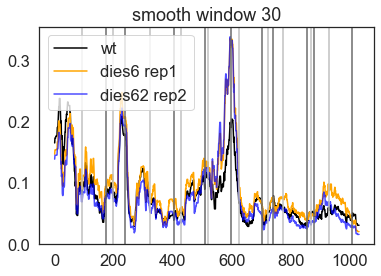

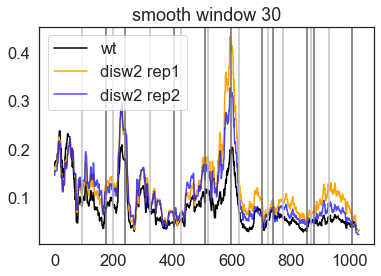

In [264]:
# How does that look over the whole sequence?
sns.set_style("white")
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [265]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3, anno)
wt_rep2_feat_me = condense_features(wt_rep2, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


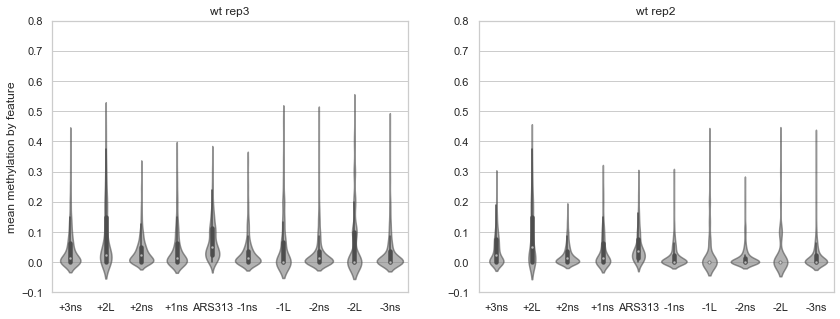

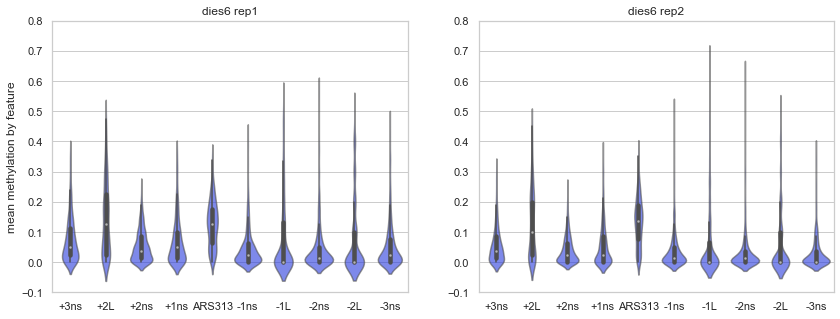

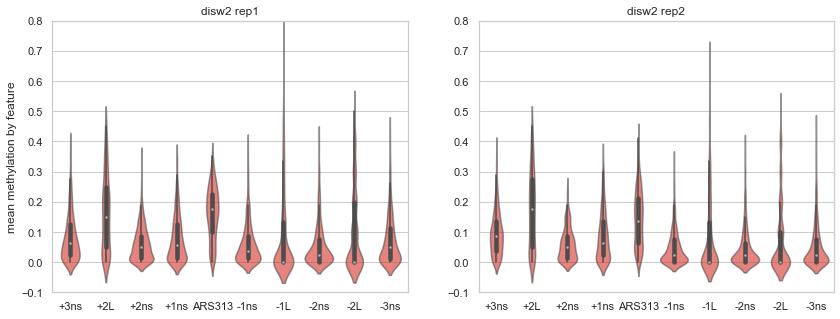

In [266]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.8)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.8)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_wt.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.8)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.8)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_dies6.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.8)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.8)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_disw2.tif")
plt.show()

In [267]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt rep2"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "dies6"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "disw2"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "mean methylation"}, inplace=True)

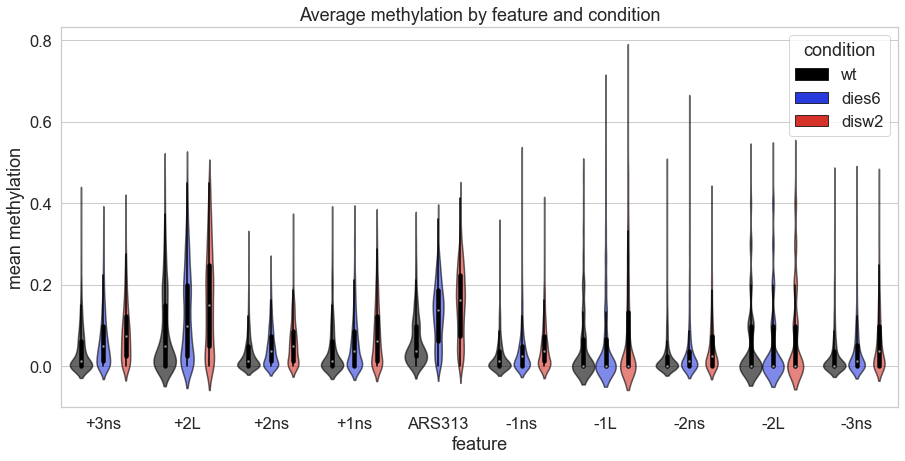

In [268]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize = (15,7))
ax = sns.violinplot(data = methylation_rep1, x="feature", y = "mean methylation", hue = "condition", 
                    palette = col_Anna)
plt.setp(ax.collections, alpha = 0.6)
plt.title("Average methylation by feature and condition")
#plt.savefig(load_dir + "/plots/ARS313_pooled_av_methylation_by_feature_anno3.tif", dpi = 300)
plt.show()

In [269]:
"""test = wt_rep3_feat_me
test2 = dies6_rep1_feat_me

from scipy.stats import mannwhitneyu

scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue

for number in range(10):
    np.random.shuffle(test[:, 7])
    np.random.shuffle(test2[:, 7])
    print(scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue)
 """

'test = wt_rep3_feat_me\ntest2 = dies6_rep1_feat_me\n\nfrom scipy.stats import mannwhitneyu\n\nscipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue\n\nfor number in range(10):\n    np.random.shuffle(test[:, 7])\n    np.random.shuffle(test2[:, 7])\n    print(scipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue)\n '

In [270]:
from scipy.stats import mannwhitneyu

#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["wt_rep3"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep3.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["wt_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
+3ns,94,174,80,0.790521,0.718880,5.797242e-13,2.915612e-42
+2L,199,239,40,0.981696,0.975161,6.903341e-16,2.756711e-46
+2ns,324,404,80,0.007223,0.000240,8.460947e-08,1.141039e-39
+1ns,429,509,80,0.459649,0.313623,3.066480e-06,1.950935e-38
ARS313,519,599,80,0.001751,0.000021,2.117864e-83,1.256078e-127
-1ns,624,704,80,0.016092,0.000932,2.010310e-05,2.376938e-45
-1L,724,739,15,0.006246,0.000103,1.293339e-02,2.146706e-04
-2ns,774,854,80,0.006067,0.000136,2.041485e-02,1.999340e-42
-2L,869,879,10,0.005895,0.000091,7.284687e-02,9.257240e-16


In [282]:
feature_pvalues[feature_pvalues.wt_rep3 < 2.5e-2]

#from scipy.stats import ttest_ind
#[ttest_ind(feat_me_wt_pool.loc[:, column], feat_me_wt_rep3.loc[:, column], 
#           alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

[0.6524921055111202,
 0.9135957416070766,
 0.014734212568000157,
 0.47287839806176424,
 0.0037251399354399244,
 0.025584411040014098,
 0.019443835948332603,
 0.023969264479711486,
 0.0103150746995424,
 0.08404791385289434]

In [272]:
feature_pvalues[feature_pvalues.dies6_rep2 >= 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
-2L,869,879,10,0.005895,0.000091,0.072847,9.257240e-16
-3ns,929,1009,80,0.126274,0.035754,0.035426,1.350404e-56


In [273]:
feature_pvalues[feature_pvalues.disw2_rep1 >= 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,


In [274]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
+3ns,94,174,80,1.558706e-30,7.243286e-85
+2L,199,239,40,1.461302e-30,6.559414e-72
+2ns,324,404,80,2.132031e-22,8.281642e-59
+1ns,429,509,80,1.195858e-18,1.041407e-60
ARS313,519,599,80,1.071832e-117,2.919744e-155
-1ns,624,704,80,5.435739e-14,4.333760e-45
-1L,724,739,15,7.437675e-01,3.136951e-07
-2ns,774,854,80,6.695610e-10,1.495549e-46
-2L,869,879,10,8.096079e-01,6.121730e-11


In [275]:
feature_pvalues[feature_pvalues.dies6_pool >= 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
-1L,724,739,15,0.743768,3.136951e-07
-2L,869,879,10,0.809608,6.121730e-11


In [276]:
feature_pvalues[feature_pvalues.disw2_pool >= 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,


In [277]:
#feature_pvalues.to_csv(load_dir + "/ARS313_p_values_avg_feature_methylation.csv")

In [278]:
#Exporting aggregated data for Anna to plot for the manuscript 
#31th May 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS313_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS313_smooth_30.index = ARS313_smooth_30.index + 1
#ARS313_smooth_30.to_csv("ARS313/ARS313_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

ARS313_FCs = pd.DataFrame.from_dict(FC)
ARS313_FCs.index = ARS313_FCs.index + 1

#ARS313_FCs.to_csv("ARS313/ARS313_smoothed_fold_changes_winsize_30.csv")